# 16. 설명변수가 없는 계층적 정규회귀모형


In [2]:
library(bayesrules)
library(tidyverse)
library(rstanarm)
library(bayesplot)
library(tidybayes)
library(broom.mixed)
library(forcats)

In [3]:
data(spotify)

In [4]:
spotify <- spotify %>% 
  select(artist, title, popularity) %>% 
  mutate(artist = fct_reorder(artist, popularity, .fun = 'mean'))

<br>

#### 데이터는 Spotify에 노래가 있는 모든 아티스트 모집단에서 샘플링된 44명의 아티스트 각각에 대한 곡과 인지도

In [5]:
spotify %>% head

artist,title,popularity
<fct>,<chr>,<dbl>
Alok,On & On,79
Alok,All The Lies,56
Alok,Hear Me Now,75
Alok,The Wall,65
Alok,Hear Me Now,52
Alok,Toda La Noche,45


In [6]:
nrow(spotify)
nlevels(spotify$artist)

[1] 350

[1] 44

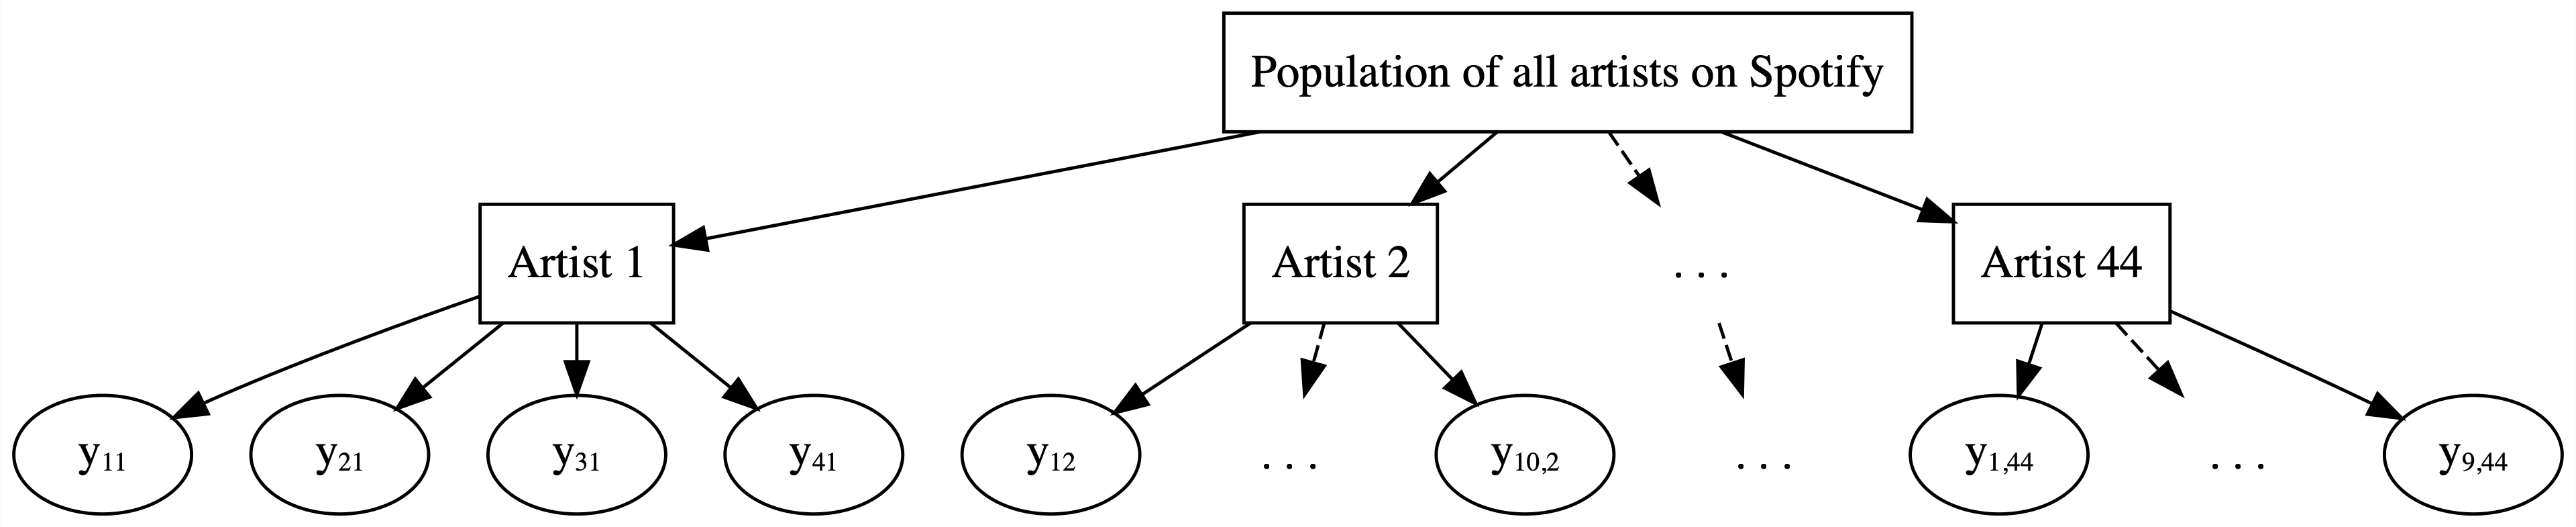

<br>

#### 각 아티스트별 곡들의 평균 인지도

In [7]:
artist_means <- spotify %>% 
  group_by(artist) %>% 
  summarize(count = n(), popularity = mean(popularity))

In [9]:
artist_means %>%
  slice(1:2, 43:44)

artist,count,popularity
<fct>,<int>,<dbl>
Mia X,4,13.25000
Chris Goldarg,10,16.40000
Lil Skies,3,79.33333
Camilo,9,81.00000


<br>

## 16.01. 완전 풀링

#### 데이터는 각 아티스트 $j \in \{1,2,\ldots,44\}$별, 곡 수를 가지고 있음 ($n_1 = 4,\;n_2=10, \dots$)

In [13]:
head(artist_means, 2)

artist,count,popularity
<fct>,<int>,<dbl>
Mia X,4,13.25
Chris Goldarg,10,16.40


In [14]:
nrow(artist_means)
artist_means$count %>% sum

[1] 44

[1] 350

$$n = \sum_{j=1}^{44} n_j = n_1 + n_2 + \cdots + n_{44} = 350  .$$

<br>

#### 만약 $j$ ($i \in \{1,2,\ldots,n_j\}$)번째 아티스트의 $i$ ($i \in \{1,2,\ldots,n_j\}$)번째곡을 $Y_{ij}$라고 한다면, 데이터는
$$Y := \left((Y_{11}, Y_{21}, \ldots, Y_{n_1,1}), (Y_{12}, Y_{22}, \ldots, Y_{n_2,2}), \ldots, (Y_{1,44}, Y_{2,44}, \ldots, Y_{n_{44},44})\right)  .$$

<br>

#### 데이터의 모든 곡들의 인지도 분포

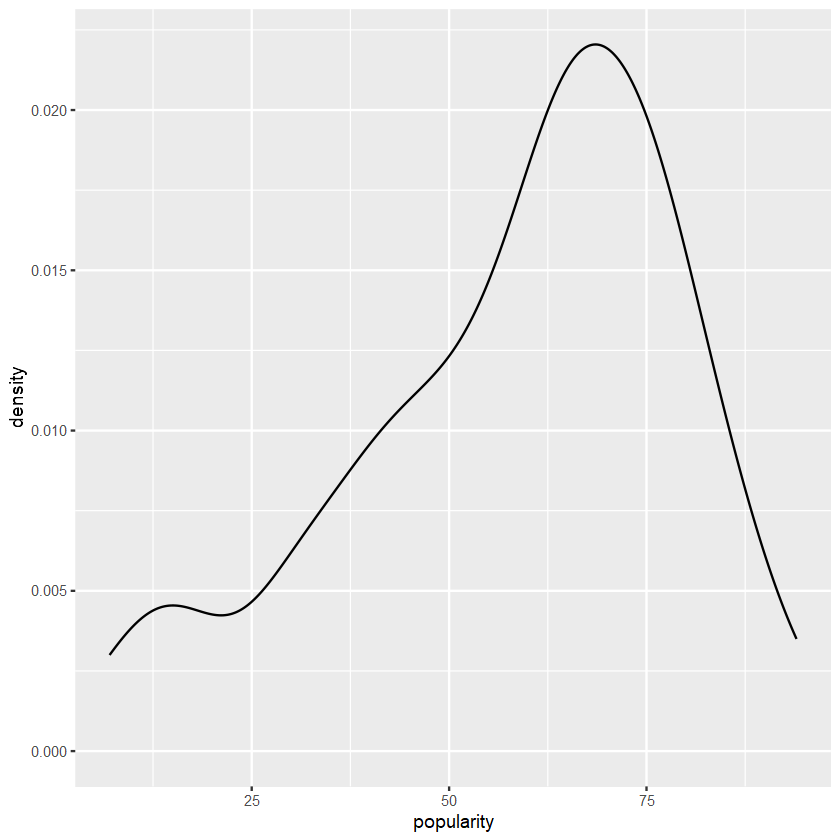

In [15]:
ggplot(spotify, aes(x = popularity)) + 
  geom_density()

<br>

### 완전풀링 적용
#### 완전풀링은 데이터 전반에 적용되는 전역평균 $\mu$와 전역표준편차$\sigma$를 가정

$$Y_{ij} | \mu, \sigma  \sim N(\mu, \sigma^2)$$

<br>


In [ ]:
spotify_complete_pooled <- stan_glm(
  popularity ~ 1, 
  data = spotify, family = gaussian, 
  prior_intercept = normal(50, 2.5, autoscale = TRUE),
  prior_aux = exponential(1, autoscale = TRUE),
  chains = 4, iter = 5000*2, seed = 84735)

In [18]:
prior_summary(spotify_complete_pooled)

Priors for model 'spotify_complete_pooled' 
------
Intercept (after predictors centered)
  Specified prior:
    ~ normal(location = 50, scale = 2.5)
  Adjusted prior:
    ~ normal(location = 50, scale = 52)

Auxiliary (sigma)
  Specified prior:
    ~ exponential(rate = 1)
  Adjusted prior:
    ~ exponential(rate = 0.048)
------
See help('prior_summary.stanreg') for more details

$$\begin{equation}
\begin{split}
Y_{ij} | \mu, \sigma & \sim N(\mu, \sigma^2) \\
\mu    & \sim N(50, 52^2) \\
\sigma & \sim \text{Exp}(0.048) \\
\end{split}
\end{equation}$$

<br>

#### 매개변수별 사후분포 통계량

In [21]:
complete_summary <- tidy(spotify_complete_pooled, 
                         effects = c("fixed", "aux"), 
                         conf.int = TRUE, conf.level = 0.80)
complete_summary

term,estimate,std.error,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),58.39279,1.0958807,57.00155,59.80605
sigma,20.66568,0.7760802,19.69461,21.70287
mean_PPD,58.39741,1.5675395,56.38017,60.40549


<br>

#### 완전풀링을 통한 사후예측분포는, 아티스트와 무관히 모든 곡에 동일하게 적용됨
#### 이는 모든 아티스트별 특성을 과도하게 일반화 하는 단점

In [23]:
set.seed(84735)
predictions_complete <- posterior_predict(spotify_complete_pooled,
                                          newdata = artist_means)

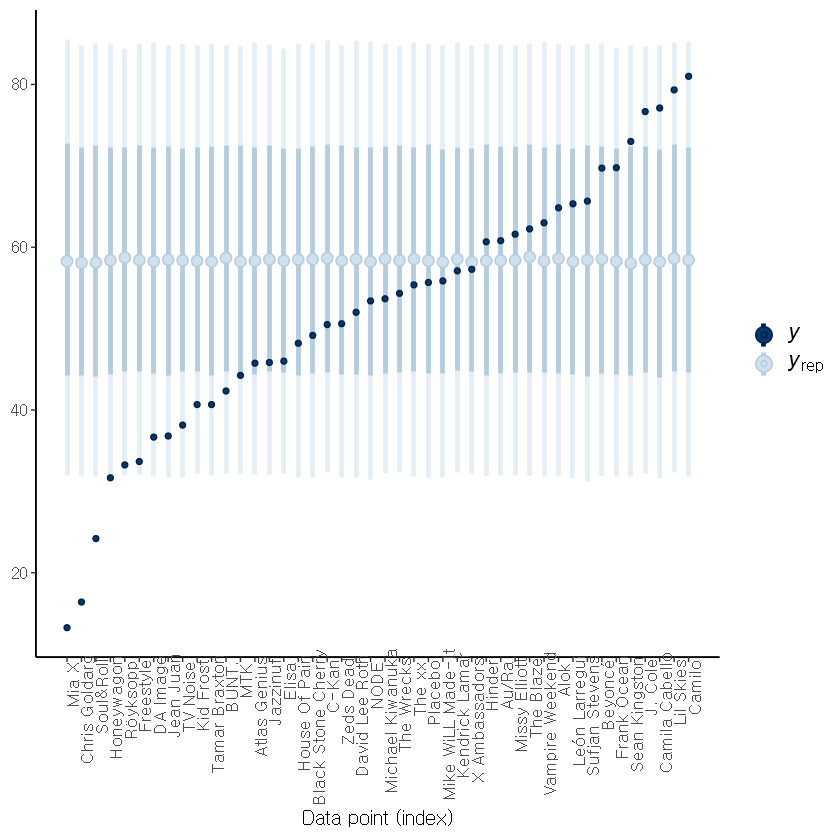

In [24]:
ppc_intervals(artist_means$popularity, yrep = predictions_complete,
              prob_outer = 0.80) +
  ggplot2::scale_x_continuous(labels = artist_means$artist,
                              breaks = 1:nrow(artist_means)) +
  xaxis_text(angle = 90, hjust = 1)

<br>

## 16.02. 개별 풀링

#### 44명의 아티스트별 곡 유명도의 분포

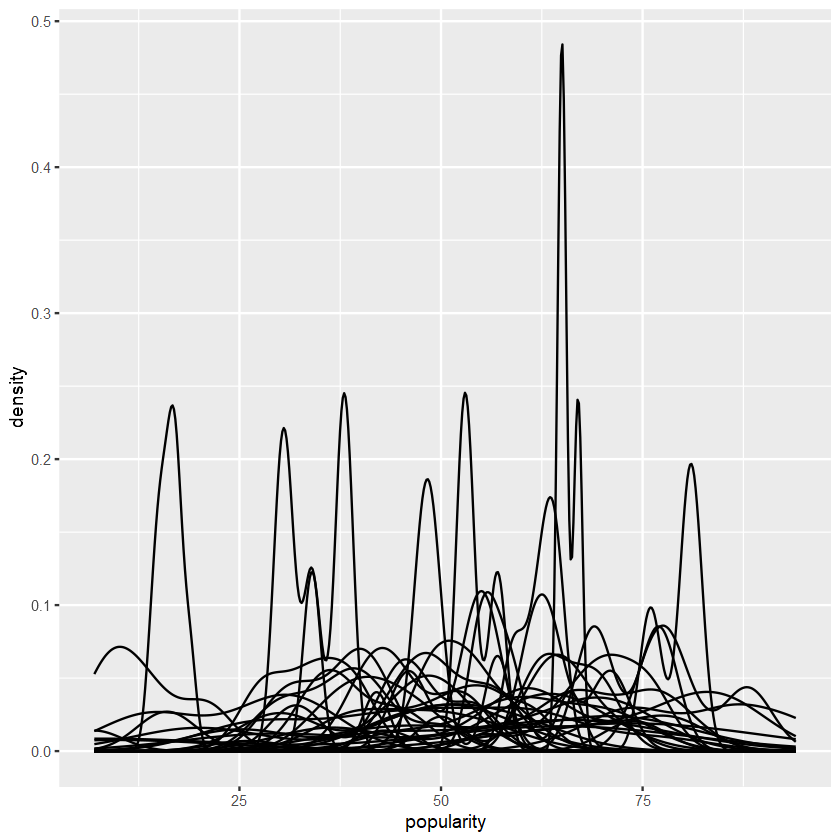

In [25]:
ggplot(spotify, aes(x = popularity, group = artist)) + 
  geom_density()

<br>

#### 개별풀링은 아티스트로 구분한 곡 그룹별 평균 $\mu_{j}$와 표준편차 $\sigma_{j}$를 가정
- 각 아티스트별 곡들은 동일한 평균과 표준편차를 공유

$$\begin{equation}
Y_{ij} | \mu_j, \sigma \sim N(\mu_j, \sigma^2)
\end{equation}$$

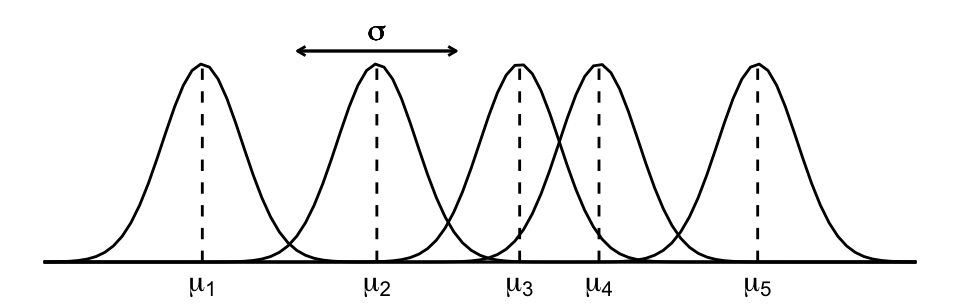

<br>

### 개별풀링 적용

In [ ]:
spotify_no_pooled <- stan_glm(
  popularity ~ artist - 1, 
  data = spotify, family = gaussian, 
  prior = normal(50, 2.5, autoscale = TRUE),
  prior_aux = exponential(1, autoscale = TRUE),
  chains = 4, iter = 5000*2, seed = 84735)

In [27]:
prior_summary(spotify_no_pooled)

Priors for model 'spotify_no_pooled' 
------

Coefficients
  Specified prior:
    ~ normal(location = [50,50,50,...], scale = [2.5,2.5,2.5,...])
  Adjusted prior:
    ~ normal(location = [50,50,50,...], scale = [484.78,309.30,434.23,...])

Auxiliary (sigma)
  Specified prior:
    ~ exponential(rate = 1)
  Adjusted prior:
    ~ exponential(rate = 0.048)
------
See help('prior_summary.stanreg') for more details

<br>

#### 개별풀링을 통한, 아티스트별 곡 인지도의 사후예측분포

In [29]:
set.seed(84735)
predictions_no <- posterior_predict(
  spotify_no_pooled, newdata = artist_means)

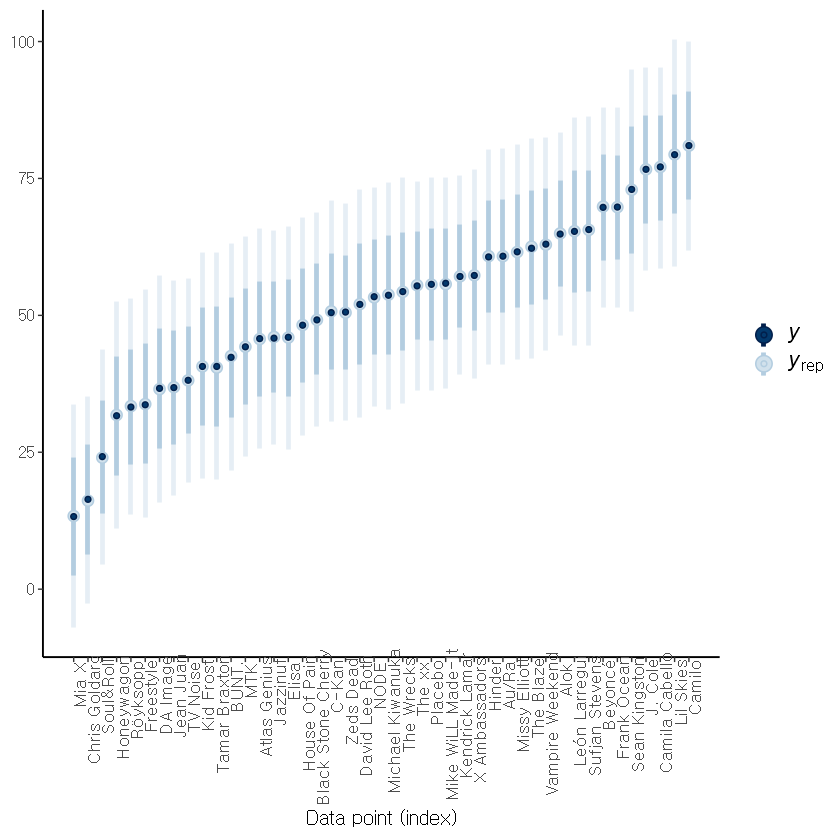

In [30]:
ppc_intervals(artist_means$popularity, yrep = predictions_no, 
              prob_outer = 0.80) +
  ggplot2::scale_x_continuous(labels = artist_means$artist, 
                              breaks = 1:nrow(artist_means)) +
  xaxis_text(angle = 90, hjust = 1)

<br>

#### 각 아티스트별 매개변수들의 사후분포는, 아티스트별 특성을 잘 설명하고 있으나, 아래와 같은 단점이 존재
1. 특정 아티스트의 사후분포를 생성할 때, 다른 아티스트들에 대한 관측값들을 무시

2. 관측값에는 없는 아티스트들의 곡 인지도에 대해서는 예측할 수 없음

<br>

## 16.03. 계층적 모형 구축

### 일원 분산분석 (ANOVA)
> 데이터가 $m$개의 그룹으로 나누어져 있을 때, ($j \in \{1,2,\ldots,m\}$) 
>
> 각 $m$개의 그룹 내 $i$번 째 관측값을을 $Y_{ij}$라고 하고, 각 그룹의 크기를 $n_j$라고 한다면,
>
> $Y_{ij}$에 대한 일원 분산분석 모형은 다음과 같다

>
> $$\begin{equation}
\begin{array}{rll}
Y_{ij} | \mu_j, \sigma_y & \sim N(\mu_j, \sigma_y^2) & \text{$j$번째 그룹내 관측값들의 변동에 대한 모형} \\
\mu_j | \mu, \sigma_\mu    & \stackrel{ind}{\sim} N(\mu, \sigma_\mu^2) & \text{그룹간 관측값 평균의 변동에 대한 모형}\\
\mu           & \sim N(m, s^2) & \text{전역평균에 대한 모형} \\
\sigma_y      & \sim \text{Exp}(l_y)    & \\
\sigma_\mu & \sim \text{Exp}(l_{\mu})    & \\
\end{array}
\end{equation}$$

<br>

<hr>

#### 위 데이터에 대한 예
$$\begin{equation}
\begin{array}{lrl}
\text{Layer 1:} & \hspace{-0.05in} Y_{ij} | \mu_j, \sigma_y   & \hspace{-0.075in} \sim \text{각 아티스트별 곡 인지도에 대한 모형} \\
\end{array}
\end{equation}$$

- $\mu_j$ : 각 아티스트별 곡 인지도 평균
- $\sigma_y$ : **그룹내 변동성**, 즉 각 아티스트 그룹내 노래간 인지도의의 표준편차

<br>

$$\begin{equation}
\begin{array}{lrl}
\text{Layer 2:} & \hspace{-0.05in} \mu_j | \mu, \sigma_\mu & \hspace{-0.075in} \sim \text{각 아티스트들간 곡 인지도 평균에 대한 모형}\\
\end{array}
\end{equation}$$

- $\mu$ : 아티스트별 곡 인지도 평균 $\mu_j$의 전역평균
- $\sigma_\mu$ : **그룹간 변동성**, 아티스트별 곡 인지도간 표준편차

<br>

$$\begin{equation}
\begin{array}{lrl}
\text{Layer 3:} & \hspace{-0.05in} \mu, \sigma_y, \sigma_\mu  & \hspace{-0.075in} \sim \text{전역평균값에 대한 사전모형} \\
\end{array}
\end{equation}$$

<br>

### 그룹내 변동성  vs 그룹간 변동성
$$\text{그룹화덴 데이터 전체의 변동성}=\text{그룹내 변동성} + \text{그룹간 변동성}$$

$$Var(Y_{ij}) = {\sigma_y}^2 +{\sigma_\mu}^2$$

$$\begin{equation}
\begin{split}
\frac{\sigma^2_y}{\sigma^2_\mu + \sigma^2_y} 
& = \text{ $\text{Var}(Y_{ij})$에서, 각 그룹내 변동성으로 설명될 수 있는 비율  } \\[-2.5ex]
\frac{\sigma^2_\mu}{\sigma^2_\mu + \sigma^2_y} 
& = \text{ $\text{Var}(Y_{ij})$에서, 그룹간 변동성으로 설명될 수 있는 비율 } \\[-2.5ex]
\end{split}
\end{equation}$$

<br>

#### 일원 분산분석에서, 특정 그룹의 관측값은, 다른 그룹의 관측값과 독립이라는 가정
#### 특정 그룹내 2개의 관측값 간의 상관관계 (그룹내 상관관계)
$$\begin{equation}
\text{Cor}(Y_{ij}, Y_{kj}) = \frac{\sigma^2_\mu}{\sigma^2_\mu + \sigma^2_y}  .
\end{equation}$$

#### 그룹별 고유한 특성을 가진 그룹화된 데이터일수록, 그룹내 상관관계가 증가 (1에 가까워짐)
#### 그룹간 유사성이 높을수록, 그룹내 상관관계가 감소 (0에 가까워짐)

<br>

## 16.04. 사후분포

### MCMC 시뮬레이션

In [ ]:
spotify_hierarchical <- stan_glmer(
  popularity ~ (1 | artist), 
  data = spotify, family = gaussian,
  prior_intercept = normal(50, 2.5, autoscale = TRUE),
  prior_aux = exponential(1, autoscale = TRUE),
  prior_covariance = decov(reg = 1, conc = 1, shape = 1, scale = 1),
  chains = 4, iter = 5000*2, seed = 84735)

### autoscale된 사전분포

In [32]:
prior_summary(spotify_hierarchical)

Priors for model 'spotify_hierarchical' 
------
Intercept (after predictors centered)
  Specified prior:
    ~ normal(location = 50, scale = 2.5)
  Adjusted prior:
    ~ normal(location = 50, scale = 52)

Auxiliary (sigma)
  Specified prior:
    ~ exponential(rate = 1)
  Adjusted prior:
    ~ exponential(rate = 0.048)

Covariance
 ~ decov(reg. = 1, conc. = 1, shape = 1, scale = 1)
------
See help('prior_summary.stanreg') for more details

$$\begin{equation}
\begin{split}
Y_{ij} | \mu_j, \sigma_y & \sim N(\mu_j, \sigma_y^2) \;\; \text{ with } \;\; \mu_j = \mu + b_{j}  \\
b_{j} | \sigma_\mu    & \stackrel{ind}{\sim} N(0, \sigma_\mu^2) \\
\mu           & \sim N(50, 52^2) \\
\sigma_y      & \sim \text{Exp}(0.048) \\
\sigma_\mu    & \sim \text{Exp}(1) \\
\end{split}
\end{equation}$$

### 사후분포

In [34]:
# mcmc_trace(spotify_hierarchical)
# mcmc_dens_overlay(spotify_hierarchical)
# mcmc_acf(spotify_hierarchical)
# neff_ratio(spotify_hierarchical)
# rhat(spotify_hierarchical)

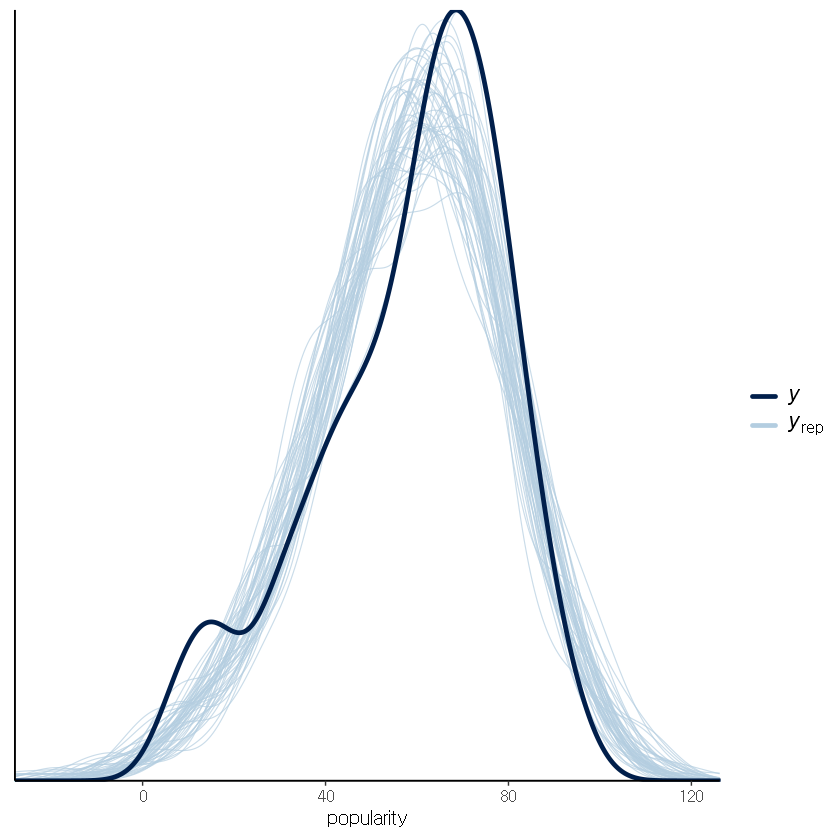

In [35]:
pp_check(spotify_hierarchical) + 
  xlab("popularity")

<br>

### 전역 매개변수의 사후분포 확인

In [36]:
spotify_hierarchical_df <- as.data.frame(spotify_hierarchical)

#### 총 47개 매개변수 
- $\mu$ : `(Intercept)`
- $\sigma_y$ : `sigma`
- $\sigma_\mu^2$ : `Sigma[artist:(Intercept),(Intercept)]`

In [39]:
tidy(spotify_hierarchical, effects = "fixed", 
     conf.int = TRUE, conf.level = 0.80)

term,estimate,std.error,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),52.39984,2.412586,49.25798,55.5482


In [60]:
spotify_hierarchical_df %>% 
    select('sigma', 'Sigma[artist:(Intercept),(Intercept)]') %>%
    tidy() %>% select(1, 3)

# tidy(spotify_hierarchical, effects = "ran_pars")

Warning message:
"Data frame tidiers are deprecated and will be removed in an upcoming release of broom."


column,mean
<chr>,<dbl>
sigma,14.02321
"Sigma[artist:(Intercept),(Intercept)]",230.21021


<br>

#### 그룹내 변동성

In [62]:
14.0321^2 /(14.02321^2 + 230.21021)

[1] 0.4612743

#### 그룹간 변동성

In [63]:
1- 14.0321^2 /(14.02321^2 + 230.21021)

[1] 0.5387257

<br>

### 그룹별 매개변수의 사후분포 확인

#### 각 그룹별 평균과 전역평균 간의 관계
$$\mu_j = \mu + b_j  .$$

In [64]:
artist_summary <- tidy(spotify_hierarchical, effects = "ran_vals", 
                       conf.int = TRUE, conf.level = 0.80)

In [68]:
artist_summary %>% 
  select(level, conf.low, conf.high) %>% 
  slice(1:2, 43:44)

level,conf.low,conf.high
<chr>,<dbl>,<dbl>
Mia_X,-40.64140,-23.13184
Chris_Goldarg,-39.18431,-26.89864
Lil_Skies,11.14401,30.44031
Camilo,19.52710,32.50634


<br>

#### 각 그룹별 평균
$$\mu_j = \mu + b_j = \text{(Intercept) + b[(Intercept) artist:j]} .$$

In [69]:
artist_chains <- spotify_hierarchical %>%
  spread_draws(`(Intercept)`, b[,artist]) %>% 
  mutate(mu_j = `(Intercept)` + b)

- 아티스트별 $b_j$의 마르코프 체인 값

In [77]:
artist_chains %>% head()

.chain,.iteration,.draw,(Intercept),artist,b,mu_j
<int>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>
1,1,1,55.88832,artist:Alok,10.884103,66.77242
1,1,1,55.88832,artist:Atlas_Genius,-17.453832,38.43448
1,1,1,55.88832,artist:Au/Ra,11.667597,67.55591
1,1,1,55.88832,artist:Beyoncé,16.495238,72.38355
1,1,1,55.88832,artist:Black_Stone_Cherry,-1.869872,54.01845
1,1,1,55.88832,artist:BUNT.,1.021085,56.90940


<br>

#### 각 아티스트별 $b_j$의 사후분포 통계량

In [72]:
artist_summary_scaled <- artist_chains %>% 
  select(-`(Intercept)`, -b) %>% 
  mean_qi(.width = 0.80) %>% 
  mutate(artist = fct_reorder(artist, mu_j))

In [73]:
artist_summary_scaled %>% 
  select(artist, mu_j, .lower, .upper) %>% 
  head(4)

artist,mu_j,.lower,.upper
<fct>,<dbl>,<dbl>,<dbl>
artist:Alok,64.26792,60.31248,68.24648
artist:Atlas_Genius,46.96622,38.81988,55.08265
artist:Au/Ra,59.54960,52.07065,67.00875
artist:BUNT.,44.65297,35.53215,53.74557


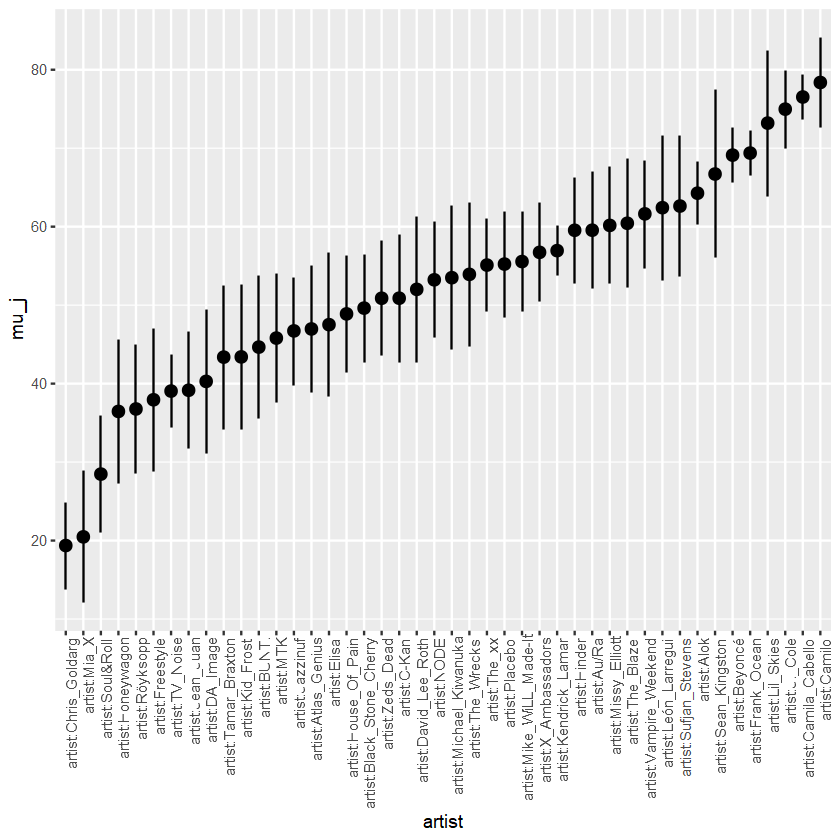

In [74]:
ggplot(artist_summary_scaled, 
       aes(x = artist, y = mu_j, ymin = .lower, ymax = .upper)) +
  geom_pointrange() +
  xaxis_text(angle = 90, hjust = 1)

<br>

## 16.05. 사후예측분포

### 이미 관측된 그룹에 대한 예측
- 신규 관측값 $Y_{new}$과, 

    각 그룹별 매개변수 $\mu_j$, $\sigma_y$의 마르코프 체인 값 $\left\lbrace \mu_j^{(i)}, \sigma_y^{(i)}\right\rbrace$을 통하여

$$\begin{equation}
Y_{\text{new,j}}^{(i)} | \mu_j, \sigma_y  \; \sim \; N\left(\mu_j^{(i)}, \left(\sigma_y^{(i)}\right)^2\right).
\end{equation}$$

$$\left\lbrace Y_{\text{new},j}^{(1)}, Y_{\text{new},j}^{(2)}, \ldots, Y_{\text{new},j}^{(20000)} \right\rbrace$$

#### 위 과정은 아래의 2가지 변동성을 고려
1. 그룹내 관측값들의 변동성
2. 그룹 매개변수의 사후 변동성

<br>

<br>

#### `Frank_Ocean`그룹에 대한 사후예측분포 생성

In [86]:
spotify_hierarchical_df %>% head()

,(Intercept),b[(Intercept) artist:Mia_X],b[(Intercept) artist:Chris_Goldarg],b[(Intercept) artist:Soul&Roll],b[(Intercept) artist:Honeywagon],b[(Intercept) artist:Röyksopp],b[(Intercept) artist:Freestyle],b[(Intercept) artist:DA_Image],b[(Intercept) artist:Jean_Juan],b[(Intercept) artist:TV_Noise],⋯,b[(Intercept) artist:Sufjan_Stevens],b[(Intercept) artist:Beyoncé],b[(Intercept) artist:Frank_Ocean],b[(Intercept) artist:Sean_Kingston],b[(Intercept) artist:J._Cole],b[(Intercept) artist:Camila_Cabello],b[(Intercept) artist:Lil_Skies],b[(Intercept) artist:Camilo],sigma,"Sigma[artist:(Intercept),(Intercept)]"
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,55.88832,-33.79092,-33.43511,-21.36295,-9.620184,-21.629453,-9.278350,-14.041552,-17.584245,-22.79035,⋯,22.276552,16.49524,13.56070,11.8681141,20.46080,19.35846,15.44872,31.25115,13.10217,229.7372
2,52.45597,-30.88413,-32.08759,-24.35386,-15.993045,-21.131797,-22.248656,-9.848127,-13.999793,-17.39005,⋯,10.640821,14.59682,16.05214,-0.4253125,24.01891,23.98681,26.26672,26.65927,13.70283,206.4501
3,53.23302,-32.99507,-27.03026,-22.53889,-9.675991,-1.852387,-15.650960,-7.592240,-14.492564,-15.09310,⋯,8.091400,18.39484,15.90873,-6.2983190,16.40558,21.67793,16.12002,24.56782,14.86667,145.6230
4,52.41409,-29.04416,-31.76350,-18.23485,-17.206222,-6.913069,-12.602770,-14.566766,-4.985226,-10.02186,⋯,8.898153,15.78035,15.68487,11.6166739,24.94042,23.24400,13.40158,21.65323,14.15979,147.6207
5,49.35362,-19.75007,-36.19538,-22.79197,-9.471749,-8.428429,-4.271702,-10.084714,-10.675647,-17.19291,⋯,11.208416,20.08549,18.97785,13.4835181,28.43464,25.54767,20.52880,25.84274,14.46488,221.1064
6,54.48250,-46.47208,-34.56217,-26.35754,-25.406497,-24.673920,-22.258507,-12.465099,-16.187794,-11.59824,⋯,12.965902,15.58933,15.80744,9.3790276,19.10403,24.09325,16.76026,28.64333,13.44918,220.0312


In [88]:
set.seed(84735)
ocean_chains <- spotify_hierarchical_df %>%
  rename(b = `b[(Intercept) artist:Frank_Ocean]`) %>% 
  select(`(Intercept)`, b, sigma) %>% 
  mutate(mu_ocean = `(Intercept)` + b,
         y_ocean = rnorm(20000, mean = mu_ocean, sd = sigma))

head(ocean_chains, 3)

,(Intercept),b,sigma,mu_ocean,y_ocean
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,55.88832,13.56070,13.10217,69.44902,78.19121
2,52.45597,16.05214,13.70283,68.50811,66.81115
3,53.23302,15.90873,14.86667,69.14175,80.75065


- **$Y_{new,j}$에 대한 사후예측분포**

In [87]:
ocean_chains %>% 
  mean_qi(y_ocean, .width = 0.80) 

y_ocean,.lower,.upper,.width,.point,.interval
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
69.35712,51.34676,87.51155,0.8,mean,qi


- **$\mu_j$에 대한 사후예측분포**

In [90]:
ocean_chains %>% 
  mean_qi(mu_ocean, .width = 0.80) 

mu_ocean,.lower,.upper,.width,.point,.interval
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
69.38182,66.54417,72.2126,0.8,mean,qi


- **$\sigma_y$에 대한 사후예측분포**

In [91]:
ocean_chains %>% 
  mean_qi(sigma, .width = 0.80) 

sigma,.lower,.upper,.width,.point,.interval
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
14.02321,13.31492,14.75372,0.8,mean,qi


<br>

### 관측되지 않은 그룹에 대한 예측

#### 그룹별 관측값 평균의 평균 $\mu$와, 그룹간 변동성 $\sigma_\mu$에 대한 마르코프 체인 값 $\left\lbrace \mu^{(i)}, \sigma_\mu^{(i)}\right\rbrace$을 통하여
#### 신규그룹의 평균에 대한 사전분포 설정

$$\mu_{\text{new group}}^{(i)} | \mu, \sigma_\mu  \; \sim \; N\left(\mu^{(i)}, \left(\sigma_\mu^{(i)}\right)^2\right).$$

#### 위에서 설정된 신규그룹의 평균에 대한 사전분포와 계산된 값 $\left\lbrace \mu_{\text{mohsen}}^{(i)}, \sigma_y^{(i)}\right\rbrace$를 통하여, 신규그룹내 관측값에 대한 사전분포 설정

$$Y_{\text{new},\text{mohsen}}^{(i)} | \mu_{\text{mohsen}}, \sigma_y  \; \sim \; N\left(\mu_{\text{mohsen}}^{(i)}, \left(\sigma_y^{(i)}\right)^2\right).$$

<br>

#### 위 절차는 아래의 3가지 변동성을 반영
1. 신규그룹내 관측값들의 변동성
2. 신규그룹 평균과 타그룹 평균간의 변동성
3. 전역 매개변수에 대한 사후 변동성

<br>


#### 신규그룹 `mohsen`에 대한 예측

In [96]:
spotify_hierarchical_df %>% head

,(Intercept),b[(Intercept) artist:Mia_X],b[(Intercept) artist:Chris_Goldarg],b[(Intercept) artist:Soul&Roll],b[(Intercept) artist:Honeywagon],b[(Intercept) artist:Röyksopp],b[(Intercept) artist:Freestyle],b[(Intercept) artist:DA_Image],b[(Intercept) artist:Jean_Juan],b[(Intercept) artist:TV_Noise],⋯,b[(Intercept) artist:Sufjan_Stevens],b[(Intercept) artist:Beyoncé],b[(Intercept) artist:Frank_Ocean],b[(Intercept) artist:Sean_Kingston],b[(Intercept) artist:J._Cole],b[(Intercept) artist:Camila_Cabello],b[(Intercept) artist:Lil_Skies],b[(Intercept) artist:Camilo],sigma,"Sigma[artist:(Intercept),(Intercept)]"
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,55.88832,-33.79092,-33.43511,-21.36295,-9.620184,-21.629453,-9.278350,-14.041552,-17.584245,-22.79035,⋯,22.276552,16.49524,13.56070,11.8681141,20.46080,19.35846,15.44872,31.25115,13.10217,229.7372
2,52.45597,-30.88413,-32.08759,-24.35386,-15.993045,-21.131797,-22.248656,-9.848127,-13.999793,-17.39005,⋯,10.640821,14.59682,16.05214,-0.4253125,24.01891,23.98681,26.26672,26.65927,13.70283,206.4501
3,53.23302,-32.99507,-27.03026,-22.53889,-9.675991,-1.852387,-15.650960,-7.592240,-14.492564,-15.09310,⋯,8.091400,18.39484,15.90873,-6.2983190,16.40558,21.67793,16.12002,24.56782,14.86667,145.6230
4,52.41409,-29.04416,-31.76350,-18.23485,-17.206222,-6.913069,-12.602770,-14.566766,-4.985226,-10.02186,⋯,8.898153,15.78035,15.68487,11.6166739,24.94042,23.24400,13.40158,21.65323,14.15979,147.6207
5,49.35362,-19.75007,-36.19538,-22.79197,-9.471749,-8.428429,-4.271702,-10.084714,-10.675647,-17.19291,⋯,11.208416,20.08549,18.97785,13.4835181,28.43464,25.54767,20.52880,25.84274,14.46488,221.1064
6,54.48250,-46.47208,-34.56217,-26.35754,-25.406497,-24.673920,-22.258507,-12.465099,-16.187794,-11.59824,⋯,12.965902,15.58933,15.80744,9.3790276,19.10403,24.09325,16.76026,28.64333,13.44918,220.0312


<br>

- 그룹별 평균의 평균 $\mu$와 표준편차 $\sigma_\mu$를 통하여, 신규그룹의 평균에 대한 사전분포 설정
- 신규그룹의 평균에 대한 사전분포와, 전체 관측값에 대한 표준편차를 통하여, 신규그룹내 관측값들에 대한 사후예측분포 생성

In [ ]:
set.seed(84735)
mohsen_chains <- spotify_hierarchical_df %>%
  mutate(sigma_mu = sqrt(`Sigma[artist:(Intercept),(Intercept)]`),
         
         # 그룹별 평균의 평균과 표준편차를 통하여, 신규그룹의 평균에 대한 사전분포 설정
         mu_mohsen = rnorm(20000, `(Intercept)`, sigma_mu),
         
         # 신규그룹의 평균에 대한 사전분포와, 전체 관측값에 대한 표준편차를 통하여, 
         # 신규그룹내 관측값들에 대한 사후예측분포 생성
         y_mohsen = rnorm(20000, mu_mohsen, sigma))

<br>

#### 신규그룹의 사후예측분포에 대한 통계량

In [93]:
mohsen_chains %>% 
  mean_qi(y_mohsen, .width = 0.80)

y_mohsen,.lower,.upper,.width,.point,.interval
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
52.2033,25.63835,78.56318,0.8,mean,qi


In [98]:
set.seed(84735)
prediction_shortcut <- posterior_predict(
  spotify_hierarchical,
  newdata = data.frame(artist = c("Frank Ocean", "Mohsen Beats")))

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


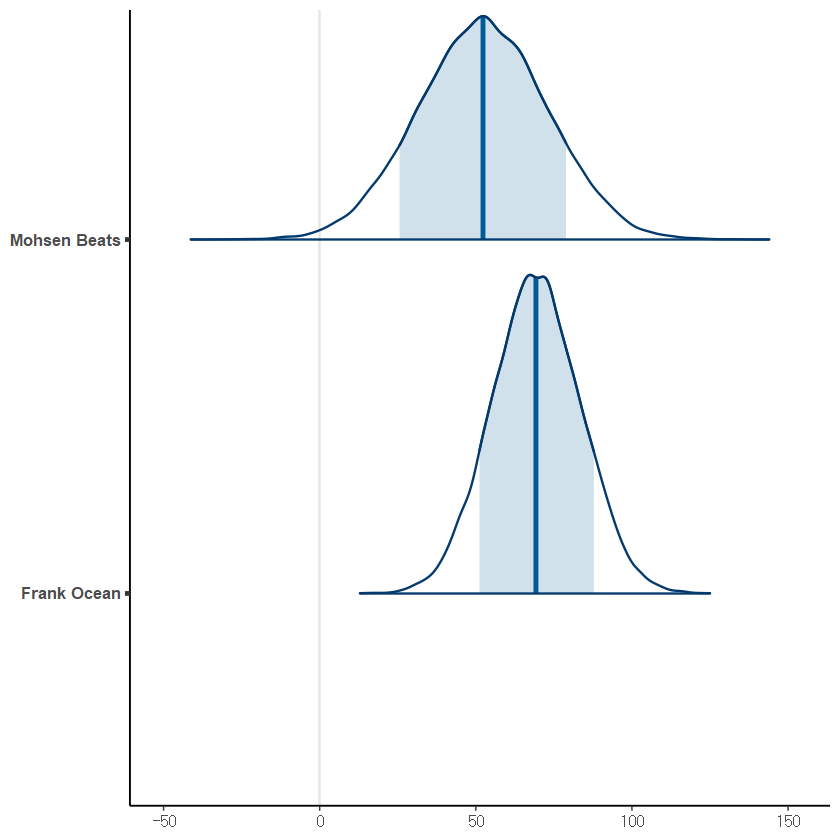

In [99]:
mcmc_areas(prediction_shortcut, prob = 0.8) +
  ggplot2::scale_y_discrete(labels = c("Frank Ocean", "Mohsen Beats"))

<br>

## 16.06. 수축 &  분산-편향 Trade Off

#### 모든 그룹의 관측값들에 대하여 사후예측분포 생성

In [101]:
set.seed(84735)
predictions_hierarchical <- posterior_predict(spotify_hierarchical, 
                                              newdata = artist_means)

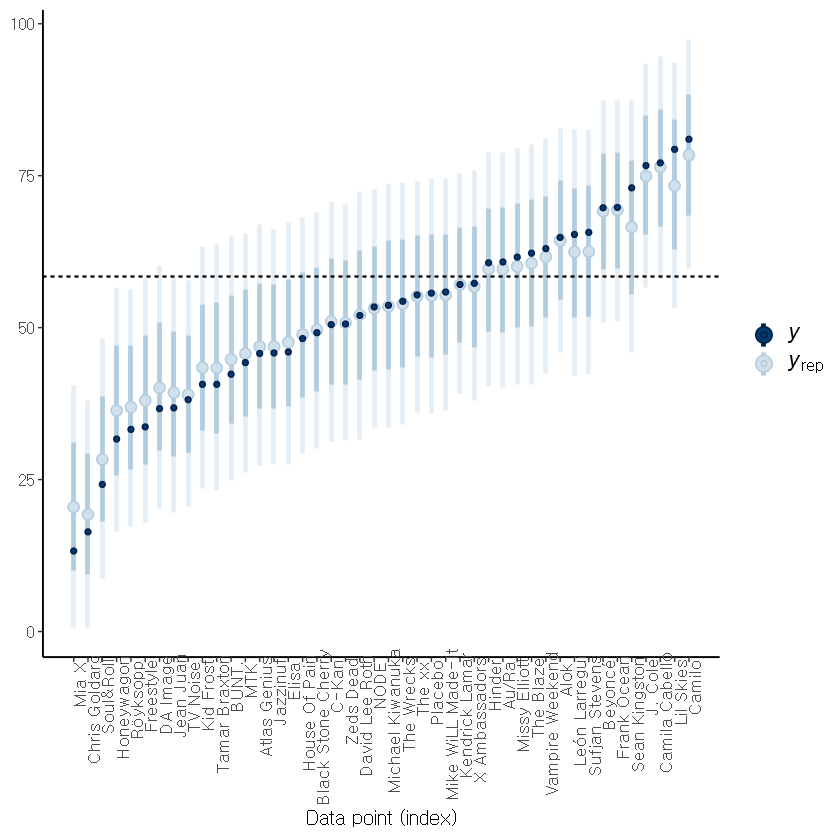

In [102]:
ppc_intervals(artist_means$popularity, yrep = predictions_hierarchical, 
              prob_outer = 0.80) +
  ggplot2::scale_x_continuous(labels = artist_means$artist, 
                              breaks = 1:nrow(artist_means)) +
  xaxis_text(angle = 90, hjust = 1) + 
  geom_hline(yintercept = 58.4, linetype = "dashed")

<br>

### 수축 (Shrinkage)
> 그룹별 특성이, 데이터 전체의 전역 특성과 비슷해지는 현상

<br>

#### 완전풀링에서의 평균 $\overline{y}_{\text{global}} = \frac{1}{n}\sum_{\text{all } i,j }y_{ij}.$과
#### 개별풀링에서의 각 그룹별 평균 $\overline{y}_j = \frac{1}{n_j}\sum_{i=1}^{n_j} y_{ij}.$에 대해서
#### 계층적 모형에서 특정 그룹의 사후예측분포 평균은, $\overline{y}_{\text{global}}$과 $y_j$들의 가중평균 형태

$$\frac{\sigma^2_y}{\sigma^2_y + n_j \sigma^2_\mu} \overline{y}_{\text{global}} + \frac{n_j\sigma^2_\mu}{\sigma^2_y + n_j \sigma^2_\mu} \overline{y}_j.$$

- **특정 그룹의 관측값 수가 적을수록, 특정 그룹의 사후예측분포 평균은 $\overline{y}_{\text{global}}$로 가까워짐 $\rightarrow $ 수축**
- **그룹내 변동성 $\sigma_{y}$가, 그룹간 변동성 $\sigma_{\mu}$보다 클수록, 특정 그룹의 사후예측분포 평균 $\overline{y}_{\text{global}}$로 가까워짐 $\rightarrow$ 수축**

<br>

### 따라서 그룹간 특성과 그룹내 특성 사이의 균형이 필요하며, 풀 개수의 조절이 필요
#### 완전풀링은 높은 편향과 낮은 분산을 유발
#### 개별풀링은 낮은 편향과 높은 분산을 유발